# CS_BP预处理部分

In [1]:
import numpy as np
import scipy.special as sc_special
import tensorflow as tf 
from 	tensorflow import keras
import pandas as pd
from tensorflow.keras import optimizers,metrics,layers,Sequential

In [105]:
# 导入数据以及预处理
data = pd.read_csv('DATASETS/GY_AIR.csv',sep=',',header=0,usecols=[1,2,3,4,5,6,7])
X = data.iloc[:400,1:]
Y = data.iloc[:400,0]
TestX = data.iloc[400:,1:]
TestY = data.iloc[400:,0]

inputnum = 6
hiddennum = 12
outputnum = 3
numsum = inputnum*hiddennum+hiddennum+hiddennum*outputnum+outputnum #6*10+10+10*3+3=103
bestfit = []
bestloss = []

def preprocess(x,y):
    x = tf.cast(x,dtype=tf.float32)
    y = tf.cast(y,dtype=tf.int32)
    y = tf.one_hot(y,depth=3)
    return x,y

In [106]:
np.mean(X,axis=0)[0]

10.8075

In [107]:
#数据预处理
#零均值处理
X.iloc[:,0] -= np.mean(X,axis=0)[0]  
X.iloc[:,1] -= np.mean(X,axis=0)[1]
X.iloc[:,2] -= np.mean(X,axis=0)[2]
X.iloc[:,3] -= np.mean(X,axis=0)[3]  
X.iloc[:,4] -= np.mean(X,axis=0)[4]
X.iloc[:,5] -= np.mean(X,axis=0)[5]
#归一化
X.iloc[:,0] /= np.max(np.abs(X),axis=0)[0]
X.iloc[:,1] /= np.max(np.abs(X),axis=0)[1]
X.iloc[:,2] /= np.max(np.abs(X),axis=0)[2]
X.iloc[:,3] /= np.max(np.abs(X),axis=0)[3]  
X.iloc[:,4] /= np.max(np.abs(X),axis=0)[4]
X.iloc[:,5] /= np.max(np.abs(X),axis=0)[5]

In [108]:
#零均值处理
TestX.iloc[:,0] -= np.mean(TestX,axis=0)[0]  
TestX.iloc[:,1] -= np.mean(TestX,axis=0)[1]
TestX.iloc[:,2] -= np.mean(TestX,axis=0)[2]
TestX.iloc[:,3] -= np.mean(TestX,axis=0)[3]  
TestX.iloc[:,4] -= np.mean(TestX,axis=0)[4]
TestX.iloc[:,5] -= np.mean(TestX,axis=0)[5]
#归一化
TestX.iloc[:,0] /= np.max(np.abs(TestX),axis=0)[0]
TestX.iloc[:,1] /= np.max(np.abs(TestX),axis=0)[1]
TestX.iloc[:,2] /= np.max(np.abs(TestX),axis=0)[2]
TestX.iloc[:,3] /= np.max(np.abs(TestX),axis=0)[3]  
TestX.iloc[:,4] /= np.max(np.abs(TestX),axis=0)[4]
TestX.iloc[:,5] /= np.max(np.abs(TestX),axis=0)[5]


In [260]:
batchsz = 32
db = tf.data.Dataset.from_tensor_slices((X,Y))
db = db.map(preprocess).shuffle(60000).batch(batchsz)
ds_val = tf.data.Dataset.from_tensor_slices((TestX,TestY))
ds_val = ds_val.map(preprocess).batch(batchsz)
sample = next(iter(db))
print(sample[0].shape,sample[1].shape)
TestY_onehot = tf.one_hot(TestY,depth=3)

(32, 6) (32, 3)


In [110]:
len(Y)

400

# CS部分

In [234]:

#n：布谷鸟数  m：布谷鸟的维度
def cuckoo_search(n, m, lower_boundary, upper_boundary, iter_num = 20,pa = 0.25, beta = 1.5, step_size = 0.1):
    """
    Cuckoo search function
    ---------------------------------------------------
    Input parameters:
        n: Number of nests
        m: Number of dimensions
        fit_func: User defined fitness evaluative function
        lower_boundary: Lower bounary (example: lower_boundary = (-2, -2, -2))
        upper_boundary: Upper boundary (example: upper_boundary = (2, 2, 2))
        iter_num: Number of iterations (default: 100) 
        pa: Possibility that hosts find cuckoos' eggs (default: 0.25)
        beta: Power law index (note: 1 < beta < 2) (default: 1.5)
        step_size:  Step size scaling factor related to the problem's scale (default: 0.1)
    Output:
        The best solution and its value
    """
    # get initial nests' locations 
    nests = generate_nests(n, m, lower_boundary, upper_boundary)
    fitness,lossness,_ = calc_fitness( nests,0.5) #包含所有的适应度  用列表存储
    
    # get the best nest and record it
    best_nest_index = np.argmin(lossness)
    best_fitness = lossness[best_nest_index]
    best_nest = nests[best_nest_index].copy()
    best_acc = 0
    bestfit.append(best_fitness) #全局变量，保存每代最佳适应度值
    

    print('\r\n BEST_TWO_LOSSNESS IS %.2f : \r\n',best_fitness)

    for _ in range(iter_num):
        nests = update_nests(lower_boundary, upper_boundary, nests, best_nest, lossness, step_size,best_fitness)
        nests = abandon_nests(nests, lower_boundary, upper_boundary, pa)
        print('\r\n*******************************************************一轮迭代后开始计算适应度*************************************************************\r\n')
        fitness,lossness,_ = calc_fitness( nests,best_fitness)
        print('\r\n*****************************************************************结束************************************************************\r\n')
        
        
        min_loss_index = np.argmin(lossness)
        min_loss = lossness[min_loss_index]
        min_loss_fit = fitness[min_loss_index]
        min_nestloss = nests[min_loss_index]
        LossArr.append(min_loss)
            
        if min_loss < best_fitness  : #and  min_loss_fit > best_two_fitness
            best_nest = min_nestloss
            best_fitness = min_loss
            best_acc = min_loss_fit
            print('\r\n******')
            print('\r\n BEST_LOSSNESS IS %.2f : \r\n',best_fitness)
            print('\r\n******\r\n')

    return (best_nest, best_fitness,best_acc)

In [235]:
def generate_nests(n, m, lower_boundary, upper_boundary):
    """
    Generate the nests' locations
    ---------------------------------------------------
    Input parameters:
        n: Number of nests
        m: Number of dimensions
        lower_boundary: Lower bounary (example: lower_boundary = (-2, -2, -2))
        upper_boundary: Upper boundary (example: upper_boundary = (2, 2, 2))
    Output:
        generated nests' locations
    """
    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    nests = np.empty((n, m))

    for each_nest in range(n):
        nests[each_nest] = lower_boundary + np.array([np.random.rand() for _ in range(m)]) * (upper_boundary - lower_boundary)

    return nests

In [236]:
def update_nests(lower_boundary, upper_boundary, nests, best_nest, lossness, step_coefficient,bestfitness):
    """
    This function is to get new nests' locations and use new better one to replace the old nest
    ---------------------------------------------------
    Input parameters:
        fit_func: User defined fitness evaluative function
        lower_boundary: Lower bounary (example: lower_boundary = (-2, -2, -2))
        upper_boundary: Upper boundary (example: upper_boundary = (2, 2, 2))
        nests: Old nests' locations 
        best_nest: Nest with best fitness
        fitness: Every nest's fitness
        step_coefficient:  Step size scaling factor related to the problem's scale (default: 0.1)
    Output:
        Updated nests' locations
    """
    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    # 莱维飞行生成步长：较长时间的短步长和较短时间的长步长
    #生成的步长的shape也是n*m，保证所有元素得到更新
    #这个步长通过step_size来控制大小
    steps = levy_flight(n, m, 1.5)
    new_nests = nests.copy()

    for each_nest in range(n):
        # coefficient 0.01 is to avoid levy flights becoming too aggresive
        # and (nest[each_nest] - best_nest) 保留了最佳nest，但会导致局部最优
        step_size = step_coefficient * steps[each_nest] # * (nests[each_nest] - best_nest)
        step_direction = np.random.rand(m) #0-1均匀概率分布生成方向
        #新的布谷鸟在原来的基础上加上步长和方向
        new_nests[each_nest] += step_size * step_direction  
        # apply boundary condtions
        new_nests[each_nest][new_nests[each_nest] < lower_boundary] = lower_boundary[new_nests[each_nest] < lower_boundary]
        new_nests[each_nest][new_nests[each_nest] > upper_boundary] = upper_boundary[new_nests[each_nest] > upper_boundary]

    new_fitness,new_losses,new_nests = calc_fitness(new_nests,bestfitness)
    #适应度更好的才更新过去
    
    nests[new_losses < lossness] = new_nests[new_losses < lossness] 
    return nests

In [237]:
def abandon_nests(nests, lower_boundary, upper_boundary, pa):
    """
    Some cuckoos' eggs are found by hosts, and are abandoned.So cuckoos need to find new nests.
    ---------------------------------------------------
    Input parameters:
        nests: Current nests' locations
        lower_boundary: Lower bounary (example: lower_boundary = (-2, -2, -2))
        upper_boundary: Upper boundary (example: upper_boundary = (2, 2, 2))
        pa: Possibility that hosts find cuckoos' eggs
    Output:
        Updated nests' locations
    """
    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    for each_nest in range(n):  
        #pa概率抛弃，抛弃后重新生成
        if (np.random.rand() < pa):
            #局部随机行走生成步长
            #随机两个种群相差*一个0-1的随机数
            step_size = np.random.rand() * (nests[np.random.randint(0, n)] - nests[np.random.randint(0, n)])
            nests[each_nest] += step_size
            # apply boundary condtions
            nests[each_nest][nests[each_nest] < lower_boundary] = lower_boundary[nests[each_nest] < lower_boundary]
            nests[each_nest][nests[each_nest] > upper_boundary] = upper_boundary[nests[each_nest] > upper_boundary]
    
    return nests

In [238]:
def levy_flight(n, m, beta):
    """
    This function implements Levy's flight.
    ---------------------------------------------------
    Input parameters:
        n: Number of steps 
        m: Number of dimensions
        beta: Power law index (note: 1 < beta < 2)
    Output:
        'n' levy steps in 'm' dimension
    """
    sigma_u = (sc_special.gamma(1+beta)*np.sin(np.pi*beta/2)/(sc_special.gamma((1+beta)/2)*beta*(2**((beta-1)/2))))**(1/beta)
    sigma_v = 1

    u =  np.random.normal(0, sigma_u, (n, m))
    v = np.random.normal(0, sigma_v, (n, m))

    steps = u/((np.abs(v))**(1/beta))

    return steps

In [239]:
def calc_fitness(nests,best_nest):
    
    n, m = nests.shape
    fitness = np.empty(n)
    lossness = np.empty(n)
    new_nests = nests
    for Sig_nest in range(n):
        chrom = nests[Sig_nest]
        #分解模型参数
        w1 = chrom[:inputnum*hiddennum]
        w1 = w1.reshape(inputnum,hiddennum)
        b1 = chrom[inputnum*hiddennum:inputnum*hiddennum+hiddennum]
        w2 = chrom[inputnum*hiddennum+hiddennum:inputnum*hiddennum+hiddennum+hiddennum*outputnum]
        w2 = w2.reshape(hiddennum,outputnum)
        b2 = chrom[inputnum*hiddennum+hiddennum+hiddennum*outputnum:]

        WB_l1 = (w1,b1)
        WB_l2 = (w2,b2)
        #创建模型，并赋予参数
        model = keras.Sequential([
            keras.layers.Dense(hiddennum,activation='relu',name='l1'),
            keras.layers.Dense(outputnum,name='l2')
        ])
        model.build(input_shape=[None,inputnum])
        
        #model.summary()
        model.compile(optimizer=optimizers.Adam(lr=0.01),
                    loss='mse',
                    metrics=['accuracy'])
        
        layer1 = model.get_layer('l1')
        layer2 = model.get_layer('l2')
        layer1.set_weights(WB_l1)
        layer2.set_weights(WB_l2)
        
        #训练模型
        #model.fit(db,epochs=1,validation_data=ds_val,validation_freq=1)
        model.fit(db,epochs=1,validation_data=ds_val,validation_freq=1)
        loss,acc = model.evaluate(db)  #这里是用验证集评估，其实应该用测试集吧 evaluate产生两个结果，前面是损失，后面是准确率
        lossness[Sig_nest] = loss
        fitness[Sig_nest] = acc  #将模型评估正确率作为适应度返回
        
        (k1,y1) = layer1.get_weights()
        (k2,y2) = layer2.get_weights()
        c=k1.reshape(1,-1).tolist()[0] + b1.reshape(1,-1).tolist()[0] + k2.reshape(1,-1).tolist()[0] + b2.reshape(1,-1).tolist()[0]
        new_nests[Sig_nest] = c
        
        
#         if(acc>bestfitness): #在计算适应度的过程当中，发现有更好的适应度就把参数保存
#             #model.save_weights('my_model_fun.h5')
#             bestfitness = acc
    return fitness,lossness,new_nests

In [240]:
# if __name__=='__main__':
low = -3*np.ones(numsum)
upp = 3*np.ones(numsum)
best_nest, best_loss,best_fitness = cuckoo_search(20,numsum, low,upp, step_size = 0.4)
 

print('CS最优loss为:%.5f!',best_loss)



13/13 [==============================] - 0s 1000us/step - loss: 16.9817 - accuracy: 0.5900

 BEST_TWO_LOSSNESS IS %.2f : 
 6.3474531173706055
13/13 [==============================] - 0s 1000us/step - loss: 9.6610 - accuracy: 0.3325

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 0s 1ms/step - loss: 6.1916 - accuracy: 0.3250

*****************************************************************结束************************************************************


******

 BEST_LOSSNESS IS %.2f : 
 3.2314765453338623

******

13/13 [==============================] - 0s 18ms/step - loss: 64.1791 - accuracy: 0.1891 - val_loss: 47.3325 - val_accuracy: 0.2800


13/13 [==============================] - 0s 1ms/step - loss: 3.8280 - accuracy: 0.4775

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 0s 1ms/step - loss: 2.3631 - accuracy: 0.4875

*****************************************************************结束************************************************************


******

 BEST_LOSSNESS IS %.2f : 
 1.5723295211791992

******

13/13 [==============================] - 1s 21ms/step - loss: 33.0164 - accuracy: 0.3818 - val_loss: 23.4251 - val_accuracy: 0.7400


13/13 [==============================] - 0s 1ms/step - loss: 5.3569 - accuracy: 0.4225

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 0s 1ms/step - loss: 1.5421 - accuracy: 0.5150

*****************************************************************结束************************************************************


******

 BEST_LOSSNESS IS %.2f : 
 1.0104753971099854

******

13/13 [==============================] - 1s 21ms/step - loss: 7.0445 - accuracy: 0.5176 - val_loss: 8.3161 - val_accuracy: 0.0800


13/13 [==============================] - 0s 1ms/step - loss: 2.6596 - accuracy: 0.3425

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 0s 1000us/step - loss: 1.0837 - accuracy: 0.5500

*****************************************************************结束************************************************************


******

 BEST_LOSSNESS IS %.2f : 
 0.627088189125061

******

13/13 [==============================] - 1s 18ms/step - loss: 13.4643 - accuracy: 0.1619 - val_loss: 5.1823 - val_accuracy: 0.3400


13/13 [==============================] - 0s 1ms/step - loss: 0.9516 - accuracy: 0.5200

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 0s 17ms/step - loss: 0.8897 - accuracy: 0.6585 - val_loss: 1.9448 - val_accuracy: 0.5400


13/13 [==============================] - 0s 1ms/step - loss: 0.5983 - accuracy: 0.5625

*****************************************************************结束************************************************************


******

 BEST_LOSSNESS IS %.2f : 
 0.45604079961776733

******

13/13 [==============================] - 0s 1000us/step - loss: 5.4792 - accuracy: 0.5500

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 1s 30ms/step - loss: 1.2189 - accuracy: 0.4636 - val_loss: 1.5987 - val_accuracy: 0.3600


13/13 [==============================] - 0s 1ms/step - loss: 0.4393 - accuracy: 0.6325

*****************************************************************结束************************************************************


******

 BEST_LOSSNESS IS %.2f : 
 0.31976577639579773

******

13/13 [==============================] - 0s 1ms/step - loss: 1.5620 - accuracy: 0.4825

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 0s 17ms/step - loss: 0.8965 - accuracy: 0.6905 - val_loss: 1.4831 - val_accuracy: 0.7000


13/13 [==============================] - 0s 999us/step - loss: 0.3321 - accuracy: 0.7075

*****************************************************************结束************************************************************

13/13 [==============================] - 0s 1ms/step - loss: 0.4921 - accuracy: 0.7075

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 0s 1ms/step - loss: 0.2648 - accuracy: 0.7525

*****************************************************************结束************************************************************


******

 BEST_LOSSNESS IS %.2f : 
 0.2648499310016632

******

13/13 [==============================] - 0s 1ms/step - loss: 1.1674 - accuracy: 0.5275

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 0s 16ms/step - loss: 7.

13/13 [==============================] - 0s 1000us/step - loss: 0.2193 - accuracy: 0.7550

*****************************************************************结束************************************************************


******

 BEST_LOSSNESS IS %.2f : 
 0.21933946013450623

******

13/13 [==============================] - 0s 1ms/step - loss: 0.9472 - accuracy: 0.5575

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 0s 1ms/step - loss: 15.9923 - accuracy: 0.0025

*****************************************************************结束************************************************************

13/13 [==============================] - 0s 916us/step - loss: 1.2414 - accuracy: 0.7000


13/13 [==============================] - 0s 2ms/step - loss: 20.4519 - accuracy: 0.0075

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 0s 1ms/step - loss: 9.9072 - accuracy: 0.0025

*****************************************************************结束************************************************************


******

 BEST_LOSSNESS IS %.2f : 
 0.21873772144317627

******

13/13 [==============================] - 0s 999us/step - loss: 10.1706 - accuracy: 0.1925

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 0s 1ms/step - loss: 5.4617 - accuracy: 0.0075

*****************************************************************结束************************************************************


******

 BEST_LOSSNESS IS %.2f : 
 0.1647230088710785

*****

13/13 [==============================] - 0s 1ms/step - loss: 2.6216 - accuracy: 0.0275

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 0s 1ms/step - loss: 1.2049 - accuracy: 0.2350

*****************************************************************结束************************************************************


******

 BEST_LOSSNESS IS %.2f : 
 0.1305065006017685

******

13/13 [==============================] - 0s 1ms/step - loss: 2.7292 - accuracy: 0.2100


13/13 [==============================] - 0s 1ms/step - loss: 1.0226 - accuracy: 0.4775

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 0s 999us/step - loss: 0.7078 - accuracy: 0.6400

*****************************************************************结束************************************************************


******

 BEST_LOSSNESS IS %.2f : 
 0.11136336624622345

******

13/13 [==============================] - 0s 1ms/step - loss: 1.1794 - accuracy: 0.6275

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 0s 17ms/step - loss: 43.9648 - accuracy: 0.3111 - val_loss: 26.1711 - val_accuracy: 0.4000


13/13 [==============================] - 0s 916us/step - loss: 0.6215 - accuracy: 0.6550

*****************************************************************结束************************************************************


******

 BEST_LOSSNESS IS %.2f : 
 0.09585484862327576

******

13/13 [==============================] - 0s 1ms/step - loss: 43.1767 - accuracy: 0.6200

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 1s 30ms/step - loss: 0.6991 - accuracy: 0.7101 - val_loss: 1.9658 - val_accuracy: 0.6000


13/13 [==============================] - 0s 1ms/step - loss: 13.3001 - accuracy: 0.5175

*****************************************************************结束************************************************************


******

 BEST_LOSSNESS IS %.2f : 
 0.09089828282594681

******

13/13 [==============================] - 0s 1000us/step - loss: 14.6733 - accuracy: 0.3100

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 0s 1ms/step - loss: 5.1422 - accuracy: 0.3575

*****************************************************************结束************************************************************


******

 BEST_LOSSNESS IS %.2f : 
 0.08628351241350174

******

13/13 [==============================] - 0s 1ms/step - loss: 4.2635 - accuracy: 0.3950

*******************************************************一轮迭代后开始计算适应度**********************************************************

13/13 [==============================] - 0s 1ms/step - loss: 3.2666 - accuracy: 0.4150

*****************************************************************结束************************************************************

13/13 [==============================] - 0s 1ms/step - loss: 4.3282 - accuracy: 0.6350

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 0s 1000us/step - loss: 2.4167 - accuracy: 0.3150

*****************************************************************结束************************************************************


******

 BEST_LOSSNESS IS %.2f : 
 0.08122154325246811

******

13/13 [==============================] - 1s 20ms/step - loss: 11.2600 - accuracy: 0.7753 - val_loss: 10.3524 - val_accuracy: 0.5800


13/13 [==============================] - 0s 1ms/step - loss: 12.3800 - accuracy: 0.3050

*******************************************************一轮迭代后开始计算适应度*************************************************************

13/13 [==============================] - 0s 1ms/step - loss: 2.1322 - accuracy: 0.6075

*****************************************************************结束************************************************************


******

 BEST_LOSSNESS IS %.2f : 
 0.0768551379442215

******

CS最优loss为:%.5f! 0.0768551379442215


# 神经网络部分

In [252]:
chrom = best_nest
w1 = chrom[:inputnum*hiddennum]
w1 = w1.reshape(inputnum,hiddennum)
b1 = chrom[inputnum*hiddennum:inputnum*hiddennum+hiddennum]
w2 = chrom[inputnum*hiddennum+hiddennum:inputnum*hiddennum+hiddennum+hiddennum*outputnum]
w2 = w2.reshape(hiddennum,outputnum)
b2 = chrom[inputnum*hiddennum+hiddennum+hiddennum*outputnum:]

WB_layer1 = (w1,b1)
WB_layer2 = (w2,b2)

In [253]:
#用CS优化初始化阈值

model = keras.Sequential([
    keras.layers.Dense(hiddennum,name='layer1',activation='relu'),
    keras.layers.Dense(outputnum,name='layer2')
])


model.build(input_shape=[None,inputnum])
#model.summary()
model.compile(optimizer=optimizers.Adam(lr=0.01),
            loss='mse',
            metrics=['accuracy'])
#model.load_weights('my_model_fun.h5')

layer1 = model.get_layer('layer1')
layer2 = model.get_layer('layer2')
layer1.set_weights(WB_layer1)
layer2.set_weights(WB_layer2)

In [254]:
#查看模型参数
# la1 = model.get_layer('layer1')
# la2 = model.get_layer('layer2')
# (k1,b1) = la1.get_weights()
# (k2,b2) = la2.get_weights()
# k1,b1,k2,b2

In [255]:
a=k1.reshape(1,-1).tolist()
b=b1.reshape(1,-1).tolist()
c = a[0] + b[0]
len(k1.reshape(1,-1).tolist()[0] + b1.reshape(1,-1).tolist()[0] + k2.reshape(1,-1).tolist()[0] + b2.reshape(1,-1).tolist()[0])

123

In [256]:
#训练模型
model.fit(db,epochs=100,validation_data=ds_val,validation_freq=5)


Epoch 1/100
13/13 [==============================] - 0s 1ms/step - loss: 0.0806 - accuracy: 0.8979
Epoch 2/100
13/13 [==============================] - 0s 1ms/step - loss: 0.0706 - accuracy: 0.9221
Epoch 3/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0622 - accuracy: 0.9186
Epoch 4/100
13/13 [==============================] - 0s 1ms/step - loss: 0.0705 - accuracy: 0.9064
Epoch 5/100
13/13 [==============================] - 0s 13ms/step - loss: 0.0614 - accuracy: 0.8929 - val_loss: 0.1146 - val_accuracy: 0.7800
Epoch 6/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0515 - accuracy: 0.9105
Epoch 7/100
13/13 [==============================] - 0s 1ms/step - loss: 0.0462 - accuracy: 0.9427
Epoch 8/100
13/13 [==============================] - 0s 1ms/step - loss: 0.0502 - accuracy: 0.9172
Epoch 9/100
13/13 [==============================] - 0s 1ms/step - loss: 0.0450 - accuracy: 0.9281
Epoch 10/100
13/13 [==============================] - 0s 6ms/step 

In [257]:
# 评估模型,不输出预测结果
loss,accuracy = model.evaluate(ds_val)
print('\ntest loss',loss)
print('accuracy',accuracy)

2/2 [==============================] - 0s 3ms/step - loss: 0.0608 - accuracy: 0.8600

test loss 0.06082410737872124
accuracy 0.8600000143051147


In [258]:
#模型预测,输入测试集,输出预测结果
y_pred = model.predict(TestX)
y_pred = tf.argmax(y_pred,axis=1)
y_pred

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2], dtype=int64)>

In [261]:
test_y = tf.argmax(TestY_onehot,axis=1)
test_y

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1,
       1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0,
       0, 2, 1, 2, 2, 2], dtype=int64)>

In [262]:
y_pred_train = model.predict(X)
y_pred_train = tf.argmax(y_pred_train,axis=1)
y_pred_train

<tf.Tensor: shape=(400,), dtype=int64, numpy=
array([2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1,
       2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2,
       2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2,
     

In [263]:
train_y = tf.argmax(Y_onehot,axis=1)
train_y

NameError: name 'Y_onehot' is not defined

# 绘图部分

In [264]:
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

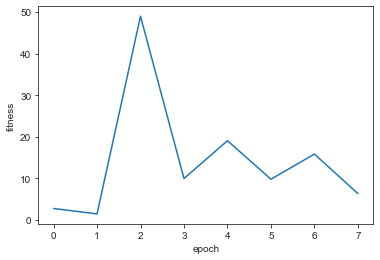

In [268]:
sns.set_style("ticks")
x = list(range(0,len(bestfit)))
fig = sns.lineplot(x,bestfit)
plt.xlabel("epoch")
plt.ylabel("fitness")
scatter_fig = fig.get_figure()
scatter_fig.savefig('./BestFit', dpi = 400)

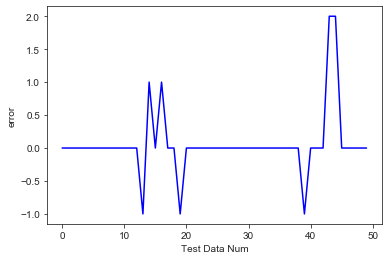

In [269]:
error = y_pred - test_y
x = list(range(0,len(error)))
fig = sns.lineplot(x,error,color="b")
plt.xlabel("Test Data Num")
plt.ylabel("error")
scatter_fig = fig.get_figure()
scatter_fig.savefig('./Error_Num', dpi = 400)



In [274]:
len(bestloss),len(bestfit)

(45, 8)

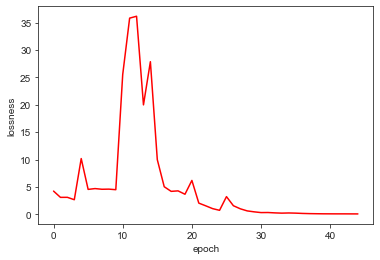

In [275]:
x = list(range(0,len(bestloss)))
fig = sns.lineplot(x,bestloss,color="r")
plt.xlabel("epoch")
plt.ylabel("lossness")
scatter_fig = fig.get_figure()
scatter_fig.savefig('./BestLoss', dpi = 400)

In [ ]:
#sns主题风格  darkgrid  whitegrid  dark  white  ticks
sns.set_style("ticks")  #设置主题风格
sns.color_palette("hls",8)  #设置颜色空间种类（几种可用颜色）
data=np.random.normal(size=(20,8)) + np.arange(8) /2
sns.boxplot(data = data,palette = sns.color_palette("hls",8))

# 描述两个变量的关系 最好用散点图

In [ ]:
import pandas as pd
mean,cov = [0,1],[(1,.5),(.5,1)]
data = np.random.multivariate_normal(mean,cov,200)
df = pd.DataFrame(data,columns=["x","y"])
#绘制散点图
sns.jointplot(x="x",y="y",data = df,color="r")  #如果点很多，用颜色深度表示数量 kind="hex" ,可以单独传x y

# 移植STM32准备

In [ ]:
Testx = X / X.max().max()
Testx = np.array(Testx)

In [ ]:
aa = []
aa.append(list(Testx[0]))
aa

In [ ]:
pre_sig=model.predict(aa)
pre_sig

In [ ]:
index = np.argmax(pre_sig,axis=None)
index

In [ ]:
Y

# 模型保存

In [ ]:
model.save('Env.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(load_model)
tflite_model = converter.convert()
open("level_check.tflite", "wb").write(tflite_model)

In [ ]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D
from tensorflow.keras import Sequential
import tensorflow.keras as keras
import numpy as np

In [ ]:


# #建立一个测试模型
model = Sequential([
    Dense(4, input_shape=(5,), name='dense_xiaoming',
          kernel_initializer='zeros',  # 全部初始化为0
          bias_initializer='ones'),  # 全部初始化为1
])



In [ ]:
x = np.ones(shape=(8, 5))  # 创建测试数据
y = model(x)
layer = model.get_layer('dense_xiaoming')  # 通过层的名字得到层
(k, b) = layer.get_weights()  # 查看层的初始化权重值和偏置项
print(k)
print(b)

In [ ]:
layer